
# Chapter 11 -> Spark ETL with Lakehouse | Delta table Optimization (Partition, ZORDER & Optimize)

Task to do 
1. Read data from CSV file to Spark
2. Create HIVE temp view from data frame
3. Load data into Delta format (create initial table)
4. Load data into Delta format with partition 
5. Apply Optimize executeCompaction on delta table 
6. Apply Optimize ZOrder on delta table
7. Check performance

In [1]:
# First Load all the required library and also Start Spark Session
# Load all the required library
from pyspark.sql import SparkSession

In [2]:
#Start Spark Session
spark = SparkSession.builder.appName("chapter11") \
        .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
        .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")  \
        .config("spark.jars.packages", "io.delta:delta-core_2.12:2.0.0")  \
        .getOrCreate()
sqlContext = SparkSession(spark)
#Dont Show warning only error
spark.sparkContext.setLogLevel("ERROR")

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
io.delta#delta-core_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-17cbeeff-04dd-41f9-964f-9c4eca7fa3de;1.0
	confs: [default]
	found io.delta#delta-core_2.12;2.0.0 in central
	found io.delta#delta-storage;2.0.0 in central
	found org.antlr#antlr4-runtime;4.8 in central
	found org.codehaus.jackson#jackson-core-asl;1.9.13 in central
:: resolution report :: resolve 350ms :: artifacts dl 22ms
	:: modules in use:
	io.delta#delta-core_2.12;2.0.0 from central in [default]
	io.delta#delta-storage;2.0.0 from central in [default]
	org.antlr#antlr4-runtime;4.8 from central in [default]
	org.codehaus.jackson#jackson-core-asl;1.9.13 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number

1. Read data from CSV file to Spark

In [ ]:
csvdf = spark.read.format("csv").option("header","true").option("inferSchema","true").load("food.csv")

In [4]:
#Checking dataframe schema
csvdf.printSchema()

root
 |-- FOODNAME: string (nullable = true)
 |-- SCIENTIFICNAME: string (nullable = true)
 |-- GROUP: string (nullable = true)
 |-- SUBGROUP: string (nullable = true)



In [5]:
csvdf.show(n=10)

+--------------+--------------------+----------------+--------------------+
|      FOODNAME|      SCIENTIFICNAME|           GROUP|            SUBGROUP|
+--------------+--------------------+----------------+--------------------+
|      Angelica|    Angelica keiskei|Herbs and Spices|               Herbs|
| Savoy cabbage|Brassica oleracea...|      Vegetables|            Cabbages|
| Silver linden|      Tilia argentea|Herbs and Spices|               Herbs|
|          Kiwi| Actinidia chinensis|          Fruits|     Tropical fruits|
|Allium (Onion)|              Allium|      Vegetables|Onion-family vege...|
|  Garden onion|         Allium cepa|      Vegetables|Onion-family vege...|
|          Leek|       Allium porrum|      Vegetables|Onion-family vege...|
|        Garlic|      Allium sativum|Herbs and Spices|               Herbs|
|        Chives|Allium schoenoprasum|Herbs and Spices|               Herbs|
| Lemon verbena|   Aloysia triphylla|Herbs and Spices|               Herbs|
+-----------

2. Create HIVE temp view from data frame

In [6]:
csvdf.createOrReplaceTempView("tempFood")

In [7]:
sqlContext.sql("SELECT * FROM tempFood").show(n=5)

+--------------+--------------------+----------------+--------------------+
|      FOODNAME|      SCIENTIFICNAME|           GROUP|            SUBGROUP|
+--------------+--------------------+----------------+--------------------+
|      Angelica|    Angelica keiskei|Herbs and Spices|               Herbs|
| Savoy cabbage|Brassica oleracea...|      Vegetables|            Cabbages|
| Silver linden|      Tilia argentea|Herbs and Spices|               Herbs|
|          Kiwi| Actinidia chinensis|          Fruits|     Tropical fruits|
|Allium (Onion)|              Allium|      Vegetables|Onion-family vege...|
+--------------+--------------------+----------------+--------------------+
only showing top 5 rows



3. Load data into Delta format (create initial table)

In [8]:
csvdf.write.format("delta").save("onprem_warehouse_food",mode='append')

In [10]:
#Load delta file into DataFrame
deltadf = spark.read.format("delta").load("onprem_warehouse_food")

In [12]:
deltadf.where("GROUP='Herbs and Spices'").count()

108

4. Load data into Delta format with partition

In [11]:
csvdf.write.format("delta").partitionBy("GROUP").save("onprem_warehouse_food1",mode='append')

In [13]:
#Load delta file into DataFrame
deltadf = spark.read.format("delta").load("onprem_warehouse_food1")

In [14]:
deltadf.where("GROUP='Herbs and Spices'").count()

108

5. Apply Optimize executeCompaction on delta table 

In [3]:
from delta.tables import *
from pyspark.sql.functions import *

deltafile = "onprem_warehouse_food1"

In [4]:
DeltaTable.isDeltaTable(spark, deltafile)

True

In [5]:
deltaTable = DeltaTable.forPath(spark, deltafile)

In [6]:
deltaTable.optimize().executeCompaction()

DataFrame[path: string, metrics: struct<numFilesAdded:bigint,numFilesRemoved:bigint,filesAdded:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,filesRemoved:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,partitionsOptimized:bigint,zOrderStats:struct<strategyName:string,inputCubeFiles:struct<num:bigint,size:bigint>,inputOtherFiles:struct<num:bigint,size:bigint>,inputNumCubes:bigint,mergedFiles:struct<num:bigint,size:bigint>,numOutputCubes:bigint,mergedNumCubes:bigint>,numBatches:bigint,totalConsideredFiles:bigint,totalFilesSkipped:bigint,preserveInsertionOrder:boolean,numFilesSkippedToReduceWriteAmplification:bigint,numBytesSkippedToReduceWriteAmplification:bigint,startTimeMs:bigint,endTimeMs:bigint>]

6. Apply Optimize ZOrder on delta table

In [8]:
deltaTable.optimize().executeZOrderBy('FOODNAME')

DataFrame[path: string, metrics: struct<numFilesAdded:bigint,numFilesRemoved:bigint,filesAdded:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,filesRemoved:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,partitionsOptimized:bigint,zOrderStats:struct<strategyName:string,inputCubeFiles:struct<num:bigint,size:bigint>,inputOtherFiles:struct<num:bigint,size:bigint>,inputNumCubes:bigint,mergedFiles:struct<num:bigint,size:bigint>,numOutputCubes:bigint,mergedNumCubes:bigint>,numBatches:bigint,totalConsideredFiles:bigint,totalFilesSkipped:bigint,preserveInsertionOrder:boolean,numFilesSkippedToReduceWriteAmplification:bigint,numBytesSkippedToReduceWriteAmplification:bigint,startTimeMs:bigint,endTimeMs:bigint>]

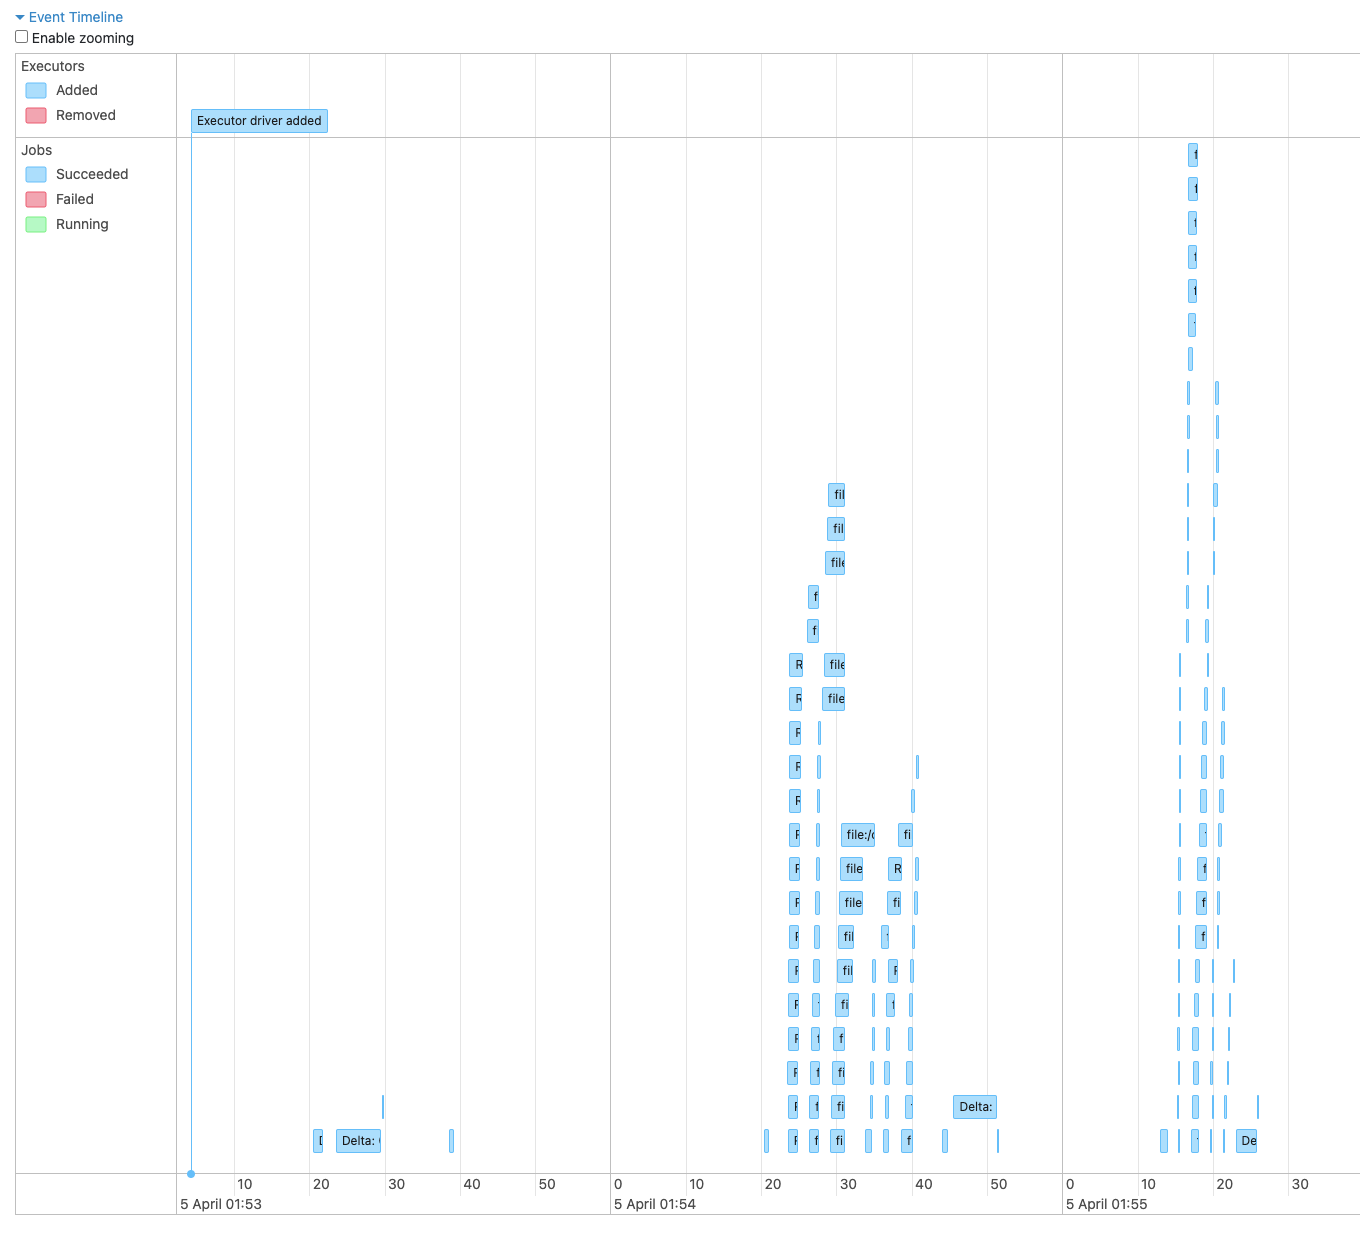